# EffNet_B5 vs EffNetV2-S on Food101 images

In [31]:
import pandas as pd
import torch

In [32]:
names = ["EfficientNet_B5", "EfficientNetV2-S"]
stats = {'top_1_acc': [83.444, 84.228],
         'top_5_acc': [96.628, 96.878],
         'params': ["30.4M", "21.5M"]}

In [33]:
stats = pd.DataFrame(stats).T
stats.columns = names
stats

,EfficientNet_B5,EfficientNetV2-S
top_1_acc,83.444,84.228
top_5_acc,96.628,96.878
params,30.4M,21.5M


I decided to see how these 2 perform on Food101 data, because as it can be seen in the table above, even though EfficientNetV2-S has ~30% less parameters, it outperforms EfficientNet_B5 on ImageNet-1K. Let's see how this difference transfers to Food101 images.

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Prepare the data

In [35]:
import torchvision
import random
import os
import shutil

### Download

In [36]:
ds = torchvision.datasets.Food101("data", download=True)

### Create a subset containing 20% of the full dataset

The full dataset is too big for experimenting, but I want to compare EfficientNet_B5 to EfficientNetV2-S and tune the hyperparameters before the final training, therefore I will create smaller subset to speed things up.

In [37]:
random.seed(17)
train_ratio = 0.75
source_dir = "data/food-101/images"
target_dir = "data/food101_20_percent"

for dir_name in ds.classes:
    source = os.path.join(source_dir, dir_name)
    train_destination = os.path.join(target_dir, "train", dir_name)
    valid_destination = os.path.join(target_dir, "valid", dir_name)

    if os.path.exists(source) and os.path.isdir(source):
        os.makedirs(train_destination, exist_ok=True)
        os.makedirs(valid_destination, exist_ok=True)

        all_images = os.listdir(source)
        random.shuffle(all_images)

        split_idx = int(len(all_images) * train_ratio)
        train_images = all_images[:split_idx:5]
        valid_images = all_images[split_idx::5]
        # print(len(train_images), len(valid_images))

        for image in train_images:
            src_image_path = os.path.join(source, image)
            dst_image_path = os.path.join(train_destination, image)
            shutil.copy2(src_image_path, dst_image_path)
        
        for image in valid_images:
            src_image_path = os.path.join(source, image)
            dst_image_path = os.path.join(valid_destination, image)
            shutil.copy2(src_image_path, dst_image_path)

## Models:

In [38]:
from torch import nn
from torchinfo import summary

In [39]:
# weights = torchvision.models.EfficientNet_B5_Weights.DEFAULT
# model = torchvision.models.efficientnet_b5(weights=weights).to(device)

# for p in model.features.parameters():
#     p.requires_grad = False

# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.4, inplace=True),
#     nn.Linear(2048, 101)
# ).to(device)

# summary(model, input_size=(32, 3, 224, 224), col_width=20, row_settings=["var_names"],
#         col_names=["input_size", "output_size", "num_params", "trainable"]), model.classifier

In [40]:
def create_effnetb5():
    weights = torchvision.models.EfficientNet_B5_Weights.DEFAULT
    model = torchvision.models.efficientnet_b5(weights=weights).to(device)
    
    for p in model.features.parameters():
        p.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(2048, 101)
    ).to(device)
    
    return model

In [41]:
# weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
# model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

# for p in model.features.parameters():
#     p.requires_grad = False

# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(1280, 101)
# ).to(device)

# summary(model, input_size=(32, 3, 224, 224), col_width=20, row_settings=["var_names"],
#         col_names=["input_size", "output_size", "num_params", "trainable"]), model.classifier

In [42]:
def create_effnet_v2s():
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
    
    for p in model.features.parameters():
        p.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(1280, 101)
    ).to(device)
    
    return model

## Load the data

In [43]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

### Transforms:

In [44]:
transform_b5 = torchvision.models.EfficientNet_B5_Weights.DEFAULT.transforms()
transform_v2s = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT.transforms()
transform_b5, transform_v2s

(ImageClassification(
     crop_size=[456]
     resize_size=[456]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 ImageClassification(
     crop_size=[384]
     resize_size=[384]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

### Datasets:

I need 4 pairs of train/valid datasets for I have 2 models and 2 subsets of data with 10 classes (for better representation of the whole dataset)

In [45]:
train_ds20p_b5 = ImageFolder("data/food101_20_percent/train", transform=transform_b5)
valid_ds20p_b5 = ImageFolder("data/food101_20_percent/valid", transform=transform_b5)

train_ds20p_v2s = ImageFolder("data/food101_20_percent/train", transform=transform_v2s)
valid_ds20p_v2s = ImageFolder("data/food101_20_percent/valid", transform=transform_v2s)

### DataLoaders

In [46]:
BATCH_SIZE = 32
num_workers = os.cpu_count() // 2 
num_workers

6

In [47]:
train_dl_20p_b5 = DataLoader(train_ds20p_b5, 
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=num_workers,
                         pin_memory=True)

valid_dl_20p_b5 = DataLoader(valid_ds20p_b5, 
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=num_workers,
                         pin_memory=True)

train_dl_20p_v2s = DataLoader(train_ds20p_v2s, 
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=num_workers,
                         pin_memory=True)

valid_dl_20p_v2s = DataLoader(valid_ds20p_v2s, 
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=num_workers,
                         pin_memory=True)

## Find learning rate

In [48]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import LambdaLR

In [49]:
class LRFinder:
    """
    My implementation of learning rate finder for pytorch, based on https://docs.fast.ai/callback.schedule.html#lrfinder
    Methods:
        LRFinder.find_lr()
        LRFinder.plot()
    """
    def __init__(self, model, dataloader, loss_fn, optimizer):
        self.model = model
        self.dataloader = dataloader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.stats = {'lr': [], 'loss': []}

    def find_lr(self, start_lr=1e-7, end_lr=10, num_iters=100):
        """
        Runs the learning rate test in a specified range.

        Args:
            start_lr: minimum learning rate to test
            end_lr: maximum learning rate to test
            num_iters: number of testing iterations
            
        I want my learning rate finder to handle only the case when all parameters have the same learning rate
        and I want my finder to be independent from learning rate set during the initialisation of optimizer, therefore
        I am setting 'lr' parameter of all parameter gropups to 1, as my scheduler is multiplying it later on
        """
        device = next(self.model.parameters()).device
        
        best_loss = float('inf')
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = 1

        lr_lambda = lambda x: start_lr * (end_lr / start_lr) ** (x/num_iters)
        scheduler = LambdaLR(self.optimizer, lr_lambda)

        epochs = num_iters // len(self.dataloader)

        for epoch in range(epochs+1):
            # set the total number of iterations in epoch for tqdm progress bar
            if epochs == 0:
                total = num_iters
            elif epoch == epochs:
                total = num_iters % len(self.dataloader)
            else:
                total = len(self.dataloader)
                
            # Separating tqdm from dataloader to avoid conflicts between them
            dl_iterator = iter(self.dataloader)
            for _ in tqdm(range(len(self.dataloader)), total=total, desc="Iterations", leave=False):
                batch, targets = next(dl_iterator)
                batch, targets = batch.to(device), targets.to(device)
                
                logits = self.model(batch)
                loss = self.loss_fn(logits, targets)
                
                best_loss = min(best_loss, loss)
                if loss > 4 * best_loss:
                    print("Loss diverged, stopping early")
                    return
            
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                self.stats['lr'].append(scheduler.get_last_lr()[0])
                self.stats['loss'].append(loss.item())
                
                scheduler.step()
                if scheduler.get_last_lr()[0] > end_lr:
                    return

    def plot(self, skip_start=0, skip_end=5):
        """
        Plots the results of the learning rate test.

        Args:
            skip_start: skip n first data points
            skip_start: skip n last data points
        """
        stats = self.stats
        
        fig = plt.figure()
        ax = fig.add_subplot()
        
        ax.plot(stats['lr'][skip_start:-skip_end], stats['loss'][skip_start:-skip_end])
        
        ax.set_xscale("log")
        ax.set_xlabel("learning rate")
        ax.set_ylabel("loss")

In [50]:
model = create_effnetb5()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1)

lr_finder = LRFinder(model, train_dl_20p_b5, loss_fn, optimizer)
lr_finder.find_lr()

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Loss diverged, stopping early


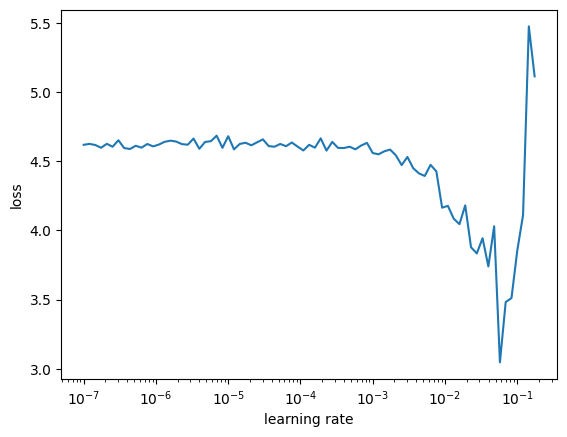

In [22]:
lr_finder.plot()

In [51]:
model = create_effnet_v2s()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1)

lr_finder = LRFinder(model, train_dl_20p_v2s, loss_fn, optimizer)
lr_finder.find_lr()

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Loss diverged, stopping early


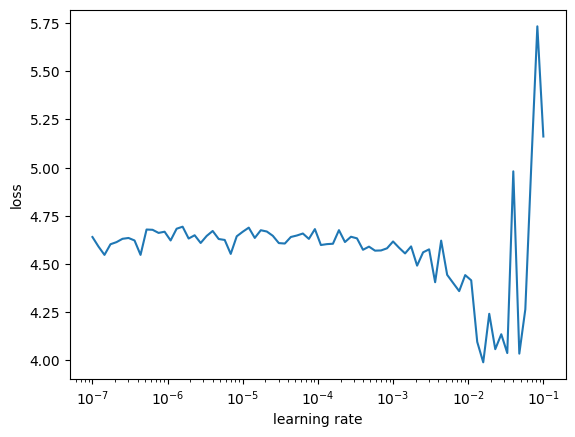

In [52]:
lr_finder.plot()

I will set the the following learning rates:

effnet_v2s lr: 0.005

effnet_b5 lr: 0.005

## Setup training functions

In [19]:
from torchmetrics import Accuracy
from torch.optim.lr_scheduler import OneCycleLR

In [20]:
def train_step(model, dataloader, optimizer, scheduler, loss_fn, device, accuracy):
    avg_accuracy = 0
    avg_loss = 0
    model.train()

    # Necessary for dataloader to work with tqdm without errors, tqdm interferes with dataloader workers shutdown process,
    # therefore I separated them
    dl_iterator = iter(dataloader)
    for _ in tqdm(range(len(dataloader)), desc="Training", leave=False):
        batch, target = next(dl_iterator)
        batch, target = batch.to(device), target.to(device)
        
        logits = model(batch)
        loss = loss_fn(logits, target)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        avg_loss += loss.item()
        avg_accuracy += accuracy(logits, target).item()

    avg_loss /= len(dataloader)
    avg_accuracy /= len(dataloader)
    return avg_loss, avg_accuracy

def valid_step(model, dataloader, loss_fn, device, accuracy):
    avg_accuracy = 0
    avg_loss = 0
    model.eval()

    # Necessary for dataloader to work with tqdm without errors
    dl_iterator = iter(dataloader)
    with torch.inference_mode():
        for _ in tqdm(range(len(dataloader)), desc="Validation", leave=False):
            batch, target = next(dl_iterator)
            batch, target = batch.to(device), target.to(device)
            
            logits = model(batch)
            loss = loss_fn(logits, target)

            avg_loss += loss.item()
            avg_accuracy += accuracy(logits, target).item()

    avg_loss /= len(dataloader)
    avg_accuracy /= len(dataloader)
    return avg_loss, avg_accuracy

In [21]:
def train(model, train_dl, valid_dl, optimizer, loss_fn, epochs, writer=None):
    device = next(iter(model.parameters())).device
    acc_fn = Accuracy(task="multiclass", num_classes=len(train_dl.dataset.classes)).to(device)
    max_lr = optimizer.defaults['lr']
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dl), epochs=epochs)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss, train_acc = train_step(
            model,
            train_dl,
            optimizer,
            scheduler,
            loss_fn,
            device,
            acc_fn
        )

        valid_loss, valid_acc = valid_step(
            model,
            valid_dl,
            loss_fn,
            device,
            acc_fn
        )

        if writer is not None:
            writer.add_scalar("train_loss", train_loss, global_step=epoch)
            writer.add_scalar("validation_loss", valid_loss, global_step=epoch)
            
            writer.add_scalar("train_accuracy", train_acc, global_step=epoch)
            writer.add_scalar("validation_accuracy", valid_acc, global_step=epoch)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

### Let's test the training functions

I will also test how long does it take to train both models for 1 epoch

In [109]:
model = create_effnetb5()

train_dl = train_dl_20p_b5
valid_dl = valid_dl_20p_b5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.03)

In [110]:
%%time
train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=1)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.2044 | train_acc: 0.3297 | valid_loss: 2.9534 | valid_acc: 0.4915
CPU times: user 6min 53s, sys: 18.2 s, total: 7min 11s
Wall time: 6min 56s


In [94]:
model = create_effnet_v2s()

train_dl = train_dl_20p_v2s
valid_dl = valid_dl_20p_v2s

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [95]:
%%time
train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=1)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9529 | train_acc: 0.3284 | valid_loss: 2.1024 | valid_acc: 0.4778
CPU times: user 2min 45s, sys: 11.9 s, total: 2min 57s
Wall time: 2min 42s


## EffNet_B5 vs EffNetV2-S

Let's compare the performance of these 2 models on a subset of Food101.

In [29]:
model_names = ["EffNet_B5", "EffNetV2-S"]

In [30]:
from torch.utils.tensorboard.writer import SummaryWriter

experiment_number = 0
for model_name in model_names:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Model: {model_name}")
    
    if model_name == "EffNet_B5":
        model = create_effnetb5()
        train_dl = train_dl_20p_b5
        valid_dl = valid_dl_20p_b5
    else:
        model = create_effnet_v2s()
        train_dl = train_dl_20p_v2s
        valid_dl = valid_dl_20p_v2s

    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
    loss_fn = nn.CrossEntropyLoss()
    writer = SummaryWriter(log_dir=f"tensorboard_stats/models_comparison/{model_name}")
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=5, writer=writer)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Model: EffNet_B5


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5818 | train_acc: 0.2884 | valid_loss: 2.2565 | valid_acc: 0.5028


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.0028 | train_acc: 0.5190 | valid_loss: 1.8200 | valid_acc: 0.5577


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.5796 | train_acc: 0.5988 | valid_loss: 1.7336 | valid_acc: 0.5768


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.2750 | train_acc: 0.6642 | valid_loss: 1.6892 | valid_acc: 0.5850


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.1127 | train_acc: 0.7073 | valid_loss: 1.6814 | valid_acc: 0.5874
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Model: EffNetV2-S


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5984 | train_acc: 0.2412 | valid_loss: 2.3802 | valid_acc: 0.4351


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.2182 | train_acc: 0.4587 | valid_loss: 2.0622 | valid_acc: 0.4894


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.8511 | train_acc: 0.5324 | valid_loss: 1.9801 | valid_acc: 0.5123


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.5392 | train_acc: 0.5950 | valid_loss: 1.9118 | valid_acc: 0.5299


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.3526 | train_acc: 0.6441 | valid_loss: 1.9058 | valid_acc: 0.5254
--------------------------------------------------



It turns out that **the bigger model performs better**, this shows that when doing transfer learning, relying solely on models performance on IMAGENET is not enough and some testing is required. However EffNetV2-S **trains 2.5x faster**, which makes me think that I shouldn't have considered those 2 models as of the same size category. I will use **EffNetV2-S** on the full dataset, because having more accuracy here is not worth the amount of extra time I would have to wait for the model to train.

If I could, I would have used **mixed precision training**, however my gpu doesn't support it. 
And I don't see any good reason to pay for google collab or some GPU server (in this particular case).

Now that I know which model I will use and I have train function and LRFinder class ready, I can move to the next stage of tuning hyper parameters. In order to keep things clean I will do it in a separate jupyter notebook